In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from src.multi_model_large_ensemble import MultiModelLargeEnsemble
import dask
from IPython.display import Image
import pylab as pl
import numpy as np

import matplotlib as mpl

In [3]:
weights_file = 'no_canesm_weights.nc'

In [4]:
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

# Global loading

In [5]:
# Decade selection

years_1 = ('2020', '2030')
years_2 = ('2040', '2050')
years_3 = ('2070', '2080')

In [6]:
years = [slice(*years_1), slice(*years_2), slice(*years_3)]

y_labels = [
    f'1st decade\n({list(years_1)[0]}-{list(years_1)[1]})',
    f'3rd decade\n({list(years_2)[0]}-{list(years_2)[1]})',
    f'6th decade\n({list(years_3)[0]}-{list(years_3)[1]})',
]

In [7]:
regions_dict = {
    'Seattle': {'lat': 47.6, 'lon': 237.7},
    'Sydney':  {'lat': -33.8, 'lon': 151.2},
    'Lagos':  {'lat': 6.5, 'lon': 3.4},
    'Montreal': {'lat': 45.5, 'lon': 286.2},
}

## Max temperature

In [8]:
models = ['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR','EC-Earth3']

In [9]:
mmle_scenarios_x=[]
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for scenario in  scenarios:
    mmle_loaded_tasmax = MultiModelLargeEnsemble('cmip6', 'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=scenario,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle_loaded_tasmax.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{scenario}_tasmax_default_quantile_return_10yr_1995_2014')
    mmle_scenarios_x.append(mmle_loaded_tasmax.x)
mmle_loaded_tasmax.x = xr.concat(mmle_scenarios_x, scenarios).rename({'concat_dim':'scenario'})

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/tasmax.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp126/day/tasmax.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/KACE-1-0-G.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/INM-CM4-8.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_tasmax_default_quantile_return_10yr_1995_2014/IPSL-CM6A-LR.

In [10]:
mmle_tasmax = MultiModelLargeEnsemble(models, 'tasmax', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
mmle_tasmax.compute_x(x_type='quantile_return', load=True, name=f'tasmax_default_quantile_return_10yr_1995_2014')
mmle_tasmax.compute_LE(weights_file=weights_file)

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/tasmax_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [11]:
mmle_tasmax.results['S_FIT'] = mmle_loaded_tasmax.x.mean('model').var('scenario').isel(member_id=0)
mmle_tasmax.results['T_LE'] = mmle_tasmax.results['S_FIT'] + mmle_tasmax.results['M_LE'] + mmle_tasmax.results['Ibar_LE']
mmle_tasmax.results['T_LE_no_S'] = mmle_tasmax.results['M_LE'] + mmle_tasmax.results['Ibar_LE']

mmle_tasmax.results['T_LE_ideal'] = mmle_tasmax.results['S_FIT'] + mmle_tasmax.results['Ibar_LE']

mmle_tasmax.results['frac_M_LE'] = mmle_tasmax.results['M_LE'] / (mmle_tasmax.results['T_LE'])
mmle_tasmax.results['frac_Ibar_LE'] = mmle_tasmax.results['Ibar_LE'] / (mmle_tasmax.results['T_LE'])
mmle_tasmax.results['frac_S_LE'] = mmle_tasmax.results['S_FIT'] / (mmle_tasmax.results['T_LE'])

In [12]:
mmle_tasmax.x.load()
mmle_tasmax.results.load()

/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:       (time: 106, lat: 71, lon: 144, model: 5)
Coordinates:
  * time          (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
  * lat           (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    degree        int64 1
    height        float64 2.0
  * model         (model) <U13 'MIROC6' 'cesm_lens' ... 'EC-Earth3'
    q_values      (model, lat, lon) float64 268.7 268.6 268.5 ... 275.7 275.7
    quantile      (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    member_id     <U8 'r1i1p1f1'
Data variables:
    M_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    I_LE          (model, time, lat, lon) float64 nan nan nan ... nan nan nan
    Ibar_LE       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    S_FIT         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE_no_S     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE_ideal    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_M_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_Ibar_LE  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_S_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [13]:
def get_global_mean(all_means):
    wights_lat = np.cos(np.deg2rad(all_means.lat))
    wights_lat /= wights_lat.mean()
    global_mean = (all_means * wights_lat).mean(('lat','lon'))
    return global_mean

In [14]:
results  = convert_longitude_360to180(mmle_tasmax.results)

In [15]:
titles = [
    "Internal variability",
    "Model uncertainty",
    "Scenario uncertainty",
]

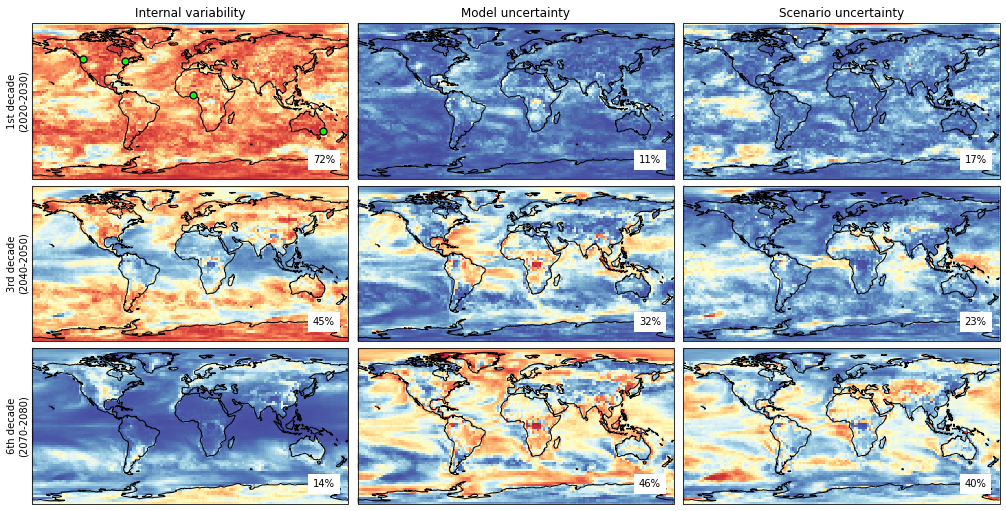

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,7), subplot_kw=dict(projection=ccrs.PlateCarree()))
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib

for axe, year_slice, y_label in zip(axes, years, y_labels):    

    data_is = [results['frac_Ibar_LE'], results['frac_M_LE'], results['frac_S_LE']]

    for ax, data_i, title in zip(axe, data_is, titles):
        
        data_decade = data_i.sel(time=year_slice).mean('time')
        percentage = int(np.round(get_global_mean(data_decade)*100).values)

        data_decade.plot(
            ax=ax, cmap=reversed_map, vmin = 0, vmax = 1, alpha=0.9, add_colorbar = False)

        ax.text(140, -70, f'{percentage}%',
            bbox={'facecolor': 'white', 
                'alpha': 1, 'pad': 5, 
                'edgecolor' : 'none'})

        if (axe == axes[0]).all():
            ax.set_title(title)
        else:
            ax.set_title(None)

        if ax == axes[0][0]:
            for region in regions_dict:
                lon = regions_dict[region]['lon']
                if lon > 180:
                    lon -= 360
                ax.plot(lon, regions_dict[region]['lat'], 'o',
                color='lime', markersize=7, markeredgecolor = 'black', markeredgewidth = 1.25)

        if ax == axe[0]:
            ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes)
        ax.coastlines(linewidth=1, color='k')
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!

In [17]:
variable = 'tasmax'
fig.savefig(f'./plots/{variable}_LE_global_fractions.png', dpi=200)

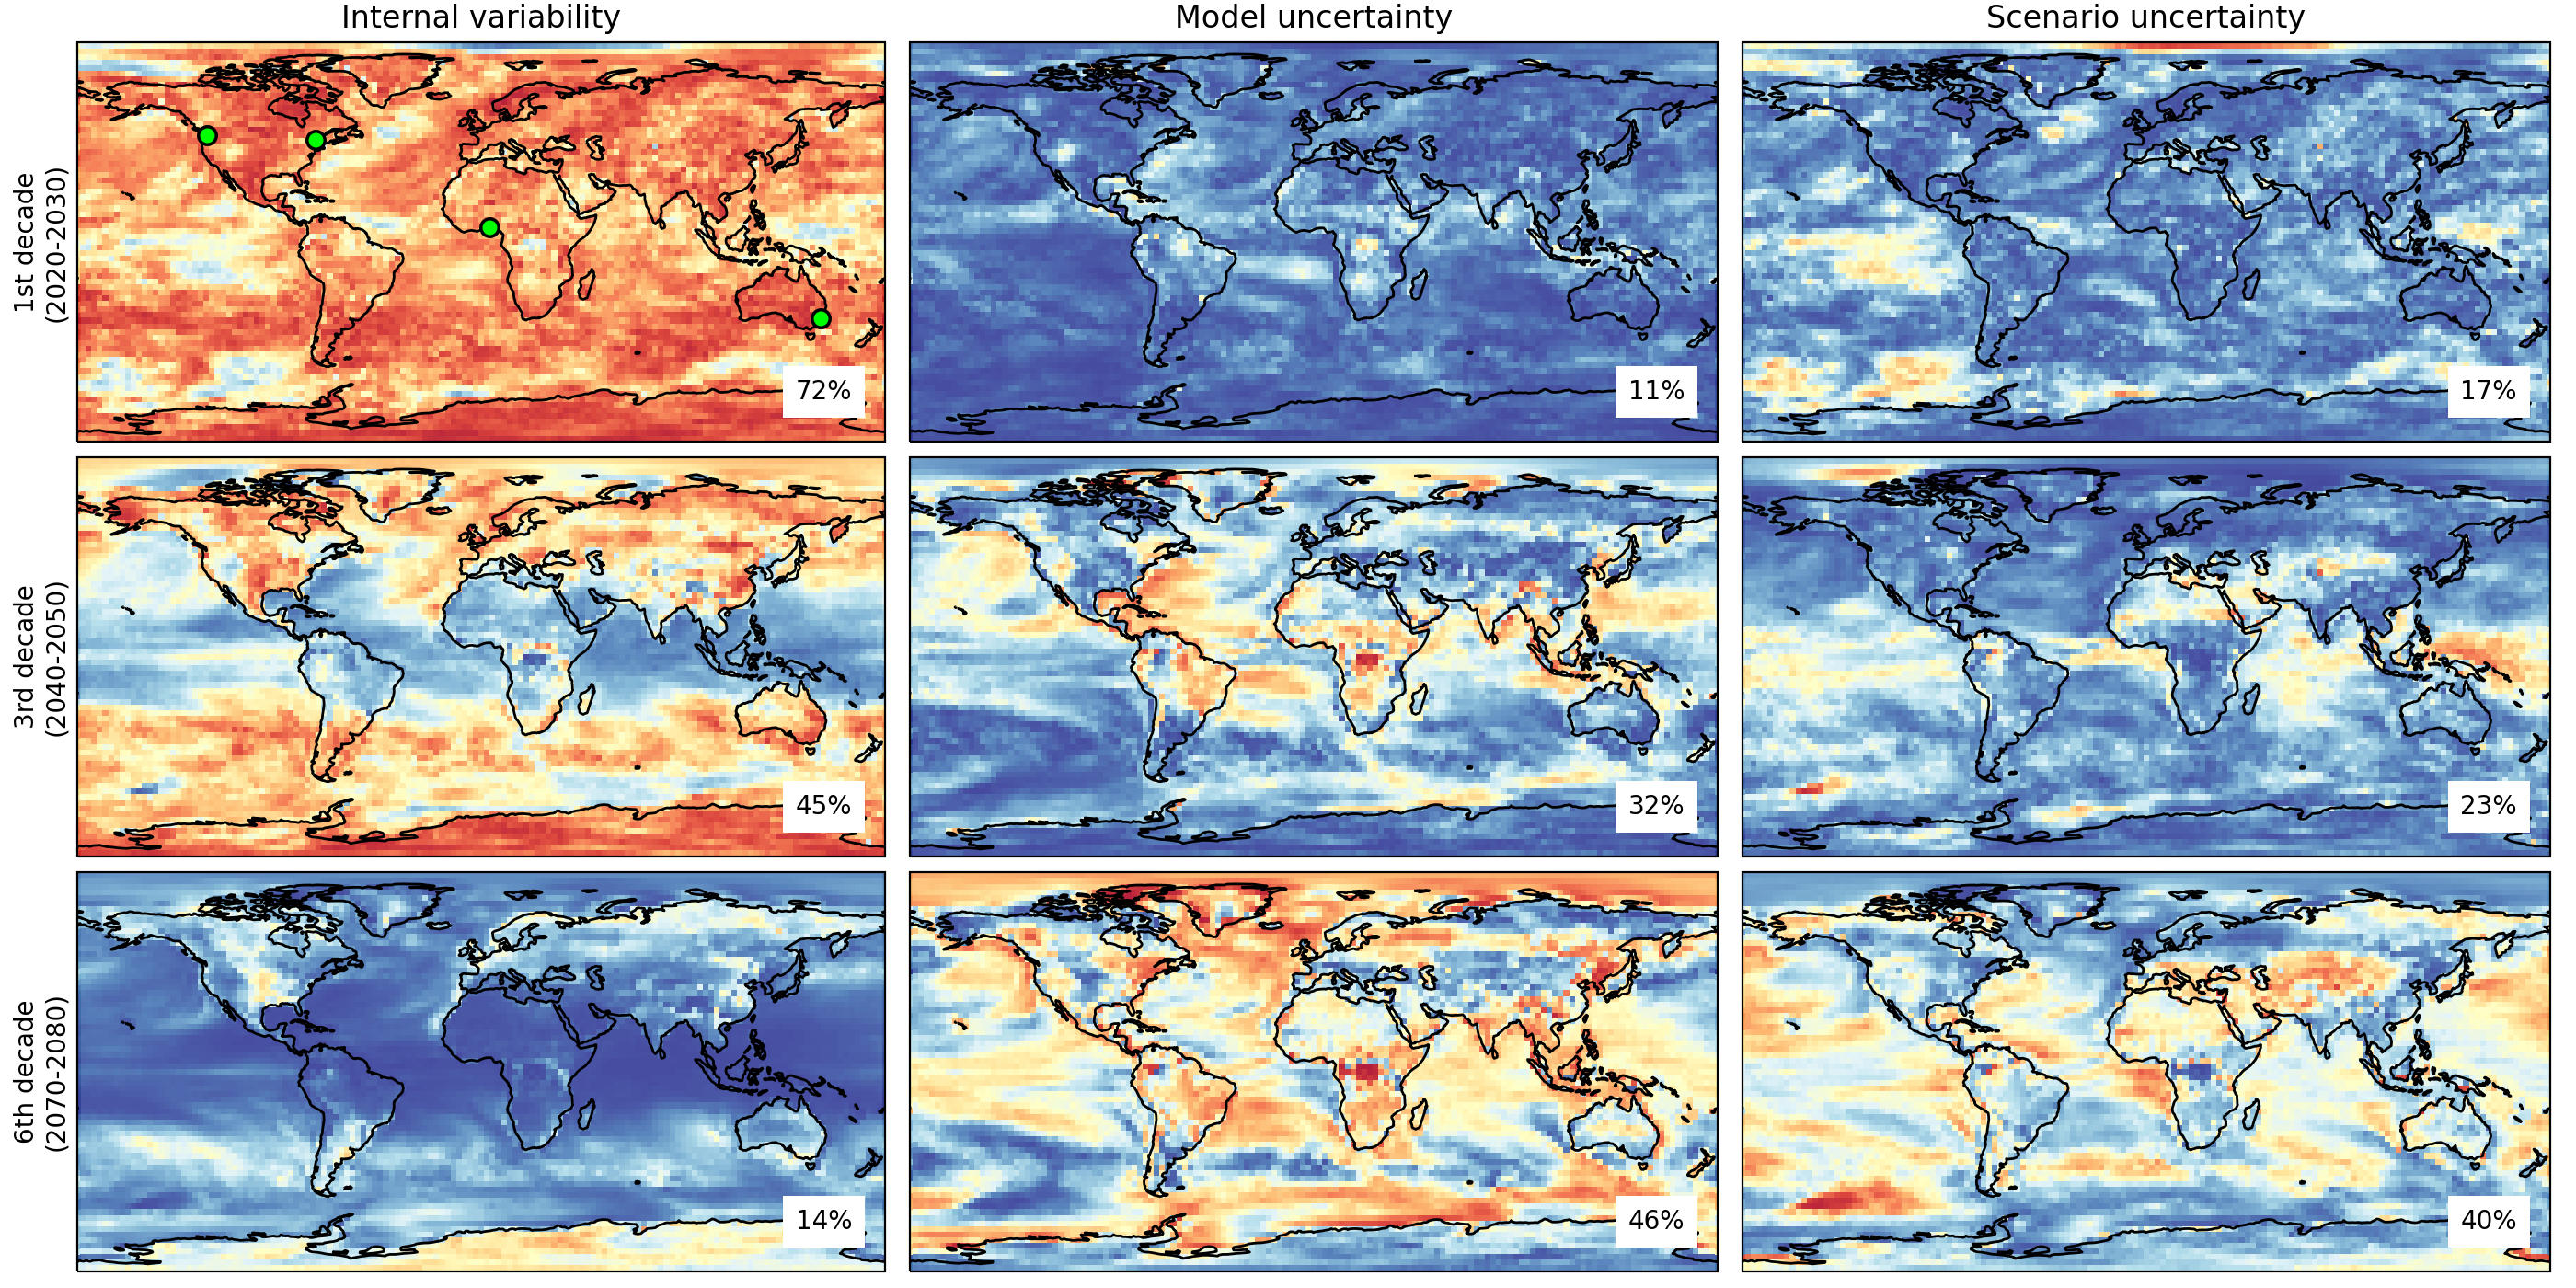

In [18]:
Image(filename=f'./plots/{variable}_LE_global_fractions.png')   # Don't believe what Jupyter shows you!

## Precipitation

In [19]:
mmle_scenarios_x=[]
scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for scenario in  scenarios:
    mmle_loaded_pr = MultiModelLargeEnsemble('cmip6', 'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), scenario=scenario,
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
    mmle_loaded_pr.compute_x(x_type='quantile_return', load=True, name=f'cmip6_{scenario}_pr_default_quantile_return_10yr_1995_2014')
    mmle_scenarios_x.append(mmle_loaded_pr.x)
mmle_loaded_pr.x = xr.concat(mmle_scenarios_x, scenarios).rename({'concat_dim':'scenario'})

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/pr.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp126/day/pr.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-HR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr_1995_2014/IPSL-CM6A-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6_ssp126_pr_default_quantile_return_10yr_1995_2014/EC-Earth3-Veg-LR.zarr
Loading: gcs://cl

In [20]:
mmle_pr = MultiModelLargeEnsemble(models, 'pr', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')
mmle_pr.compute_x(x_type='quantile_return', load=True, name=f'pr_default_quantile_return_10yr_1995_2014')
mmle_pr.compute_LE(weights_file=weights_file)

Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/MIROC6.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/cesm_lens.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/CanESM5.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/MPI-ESM1-2-LR.zarr
Loading: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/pr_default_quantile_return_10yr_1995_2014/EC-Earth3.zarr


In [21]:
mmle_pr.results['S_FIT'] = mmle_loaded_pr.x.mean('model').var('scenario').isel(member_id=0)
mmle_pr.results['T_LE'] = mmle_pr.results['S_FIT'] + mmle_pr.results['M_LE'] + mmle_pr.results['Ibar_LE']
mmle_pr.results['T_LE_no_S'] = mmle_pr.results['M_LE'] + mmle_pr.results['Ibar_LE']

mmle_pr.results['T_LE_ideal'] = mmle_pr.results['S_FIT'] + mmle_pr.results['Ibar_LE']



mmle_pr.results['frac_M_LE'] = mmle_pr.results['M_LE'] / (mmle_pr.results['T_LE'])
mmle_pr.results['frac_Ibar_LE'] = mmle_pr.results['Ibar_LE'] / (mmle_pr.results['T_LE'])
mmle_pr.results['frac_S_LE'] = mmle_pr.results['S_FIT'] / (mmle_pr.results['T_LE'])

In [22]:
mmle_pr.x.load()
mmle_pr.results.load()

/opt/conda/envs/carla/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:       (time: 106, lat: 71, lon: 144, model: 5)
Coordinates:
  * time          (time) datetime64[ns] 1995-01-01 1996-01-01 ... 2100-01-01
  * lat           (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    degree        int64 1
    height        float64 2.0
  * model         (model) <U13 'MIROC6' 'cesm_lens' ... 'EC-Earth3'
    q_values      (model, lat, lon) float64 4.335e-05 4.29e-05 ... 0.0001433
    quantile      (model) float64 0.9997 0.9997 0.9997 0.9997 0.9997
    member_id     <U8 'r1i1p1f1'
Data variables:
    M_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    I_LE          (model, time, lat, lon) float64 nan nan nan ... nan nan nan
    Ibar_LE       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    S_FIT         (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE_no_S     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE_ideal    (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_M_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_Ibar_LE  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_S_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [23]:
results  = convert_longitude_360to180(mmle_pr.results)

In [24]:
titles = [
    "Internal variability",
    "Model uncertainty",
    "Scenario uncertainty",
]

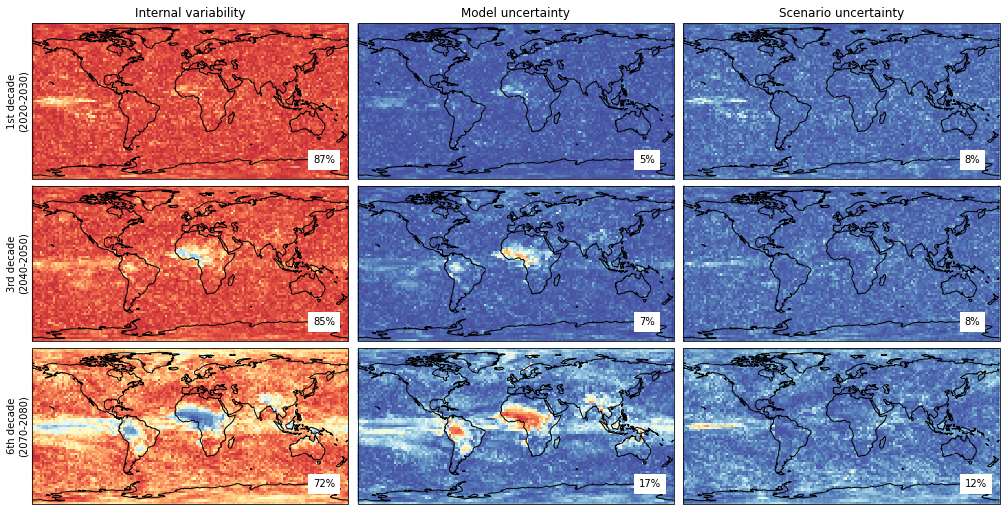

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,7), subplot_kw=dict(projection=ccrs.PlateCarree()))
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib

for axe, year_slice, y_label in zip(axes, years, y_labels):    

    data_is = [results['frac_Ibar_LE'], results['frac_M_LE'], results['frac_S_LE']]

    for ax, data_i, title in zip(axe, data_is, titles):
        data_decade = data_i.sel(time=year_slice).mean('time')
        percentage = int(np.round(get_global_mean(data_decade)*100).values)

        data_decade.plot(
            ax=ax, cmap=reversed_map, vmin = 0, vmax = 1, alpha=0.9, add_colorbar = False)

        ax.text(140, -70, f'{percentage}%',
            bbox={'facecolor': 'white', 
                'alpha': 1, 'pad': 5, 
                'edgecolor' : 'none'})

        if (axe == axes[0]).all():
            ax.set_title(title)
        else:
            ax.set_title(None)

        if ax == axe[0]:
            ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes)
        ax.coastlines(linewidth=1, color='k')
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!

In [26]:
variable = 'pr'
fig.savefig(f'./plots/{variable}_LE_global_fractions.png', dpi=200)

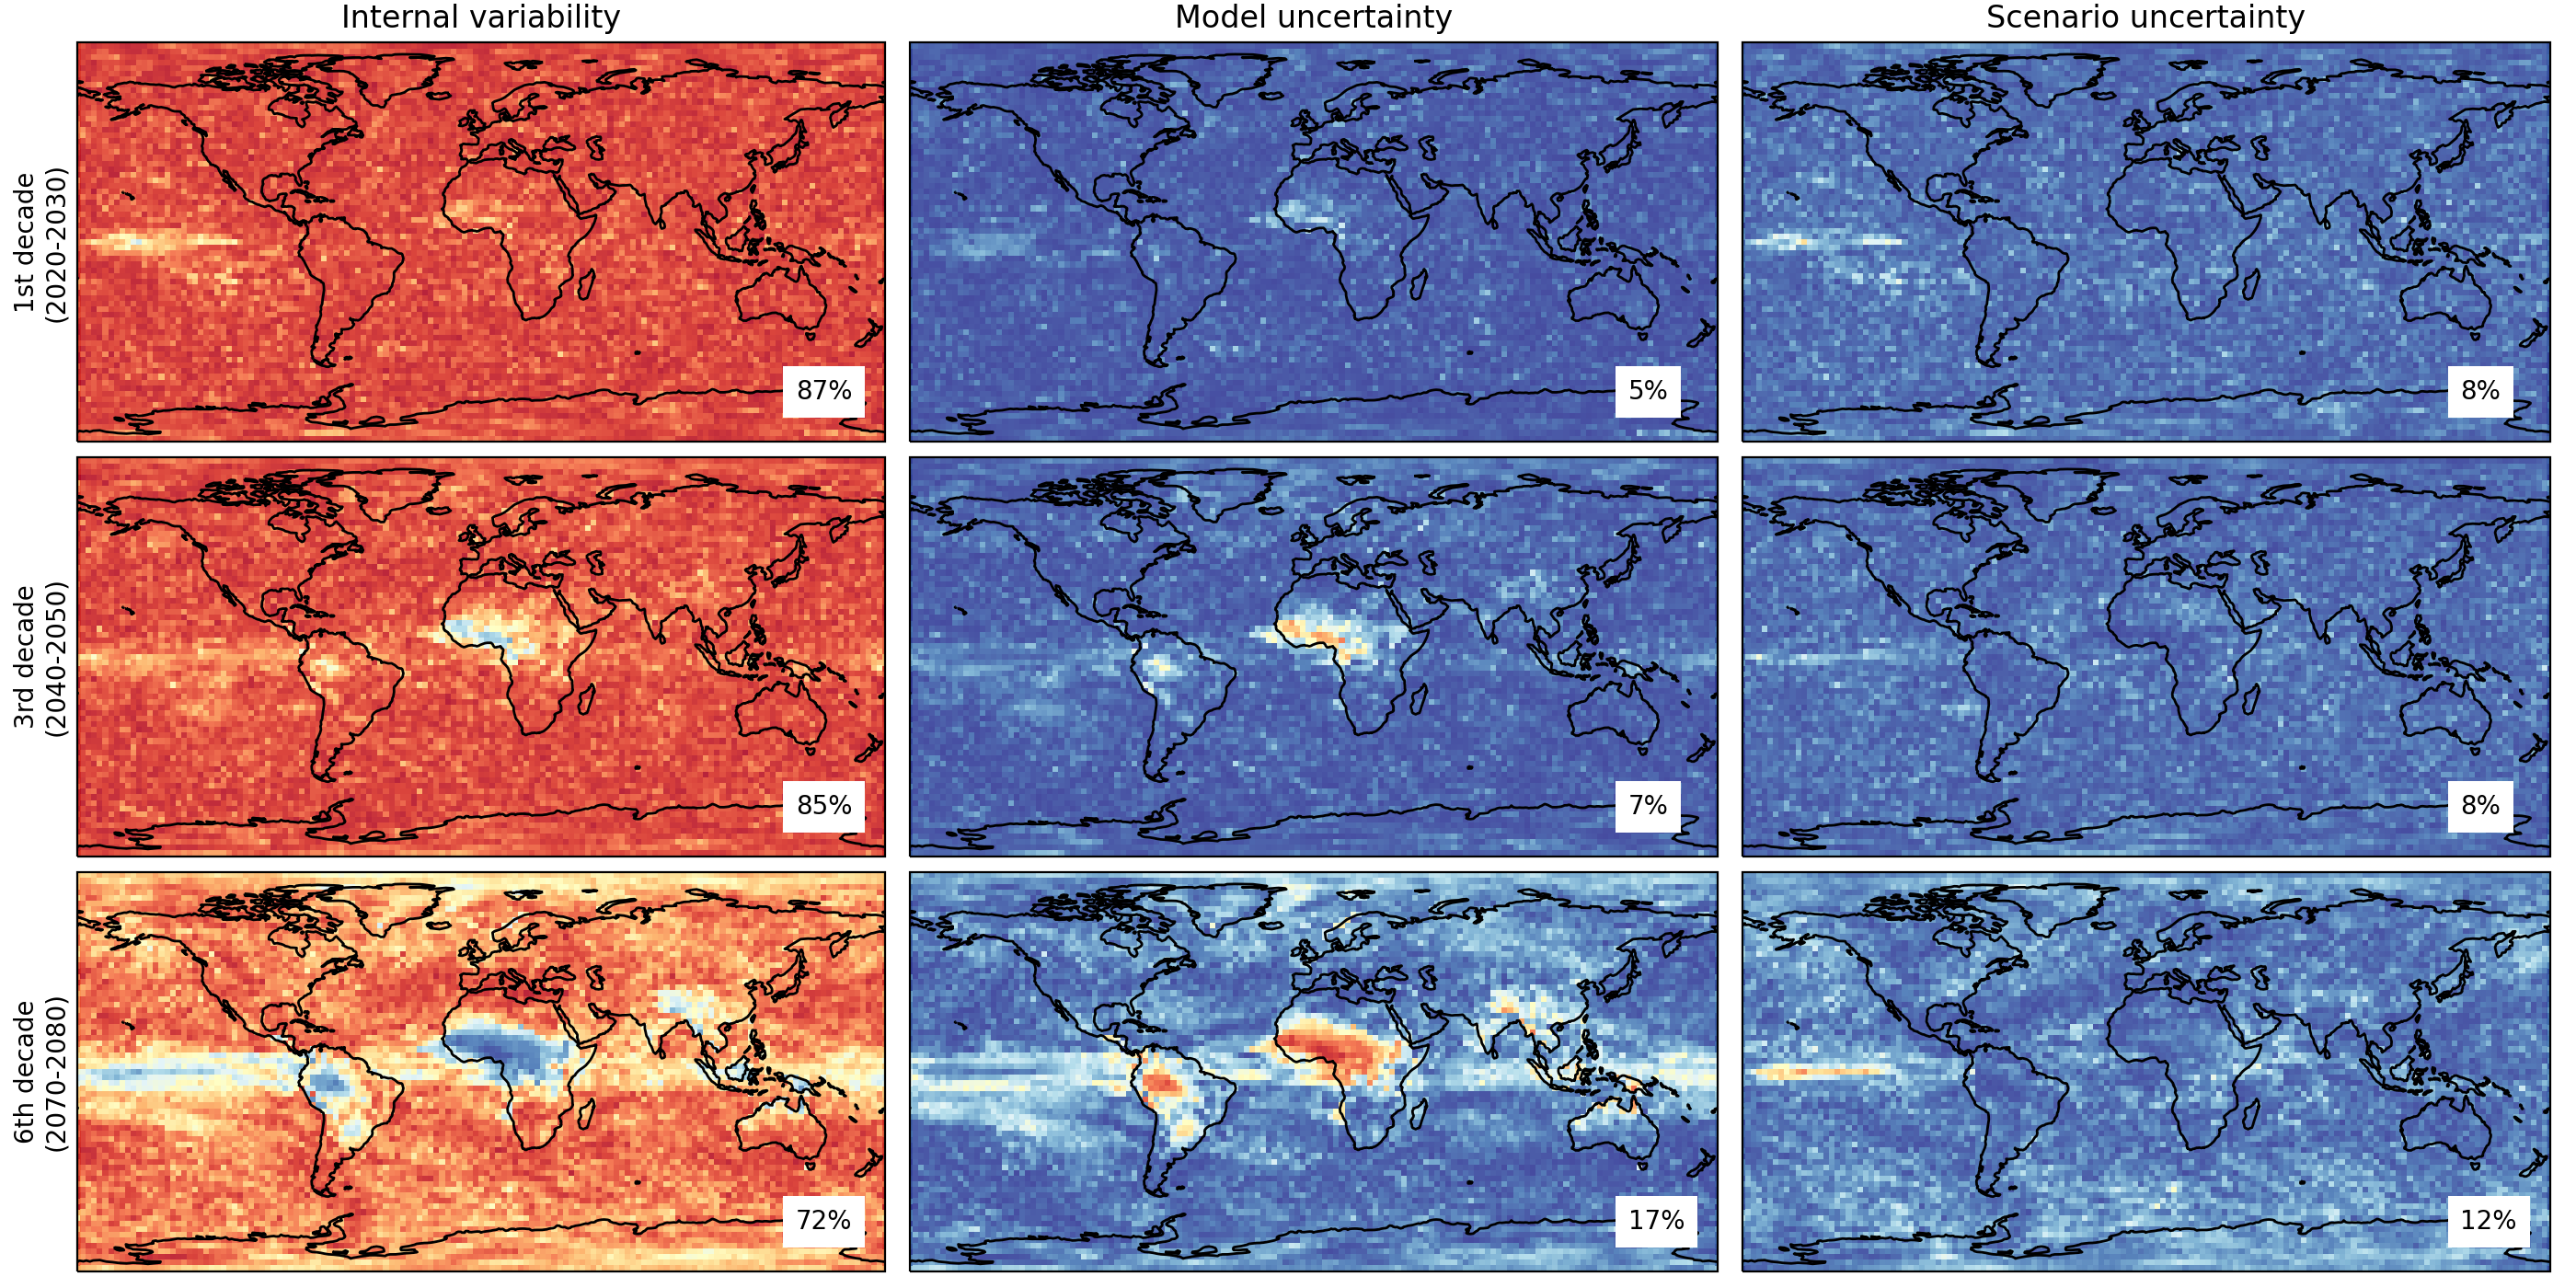

In [27]:
Image(filename=f'./plots/{variable}_LE_global_fractions.png')   # Don't believe what Jupyter shows you!

## Contributions

In [28]:
data =[
    mmle_tasmax.results,
    mmle_pr.results
]

In [29]:
titles = [
    'a) Daily Maximum Temperature',
    'b) Daily Precipitation'
]
y_labels = [
    'Percent Contribution to Total Uncertainty',
    None
]

/tmp/ipykernel_11560/62147378.py:25: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.07, right=0.99, bottom=0.1, top=0.9, wspace=0.20, hspace=0.3)  # all parameters MUST be specified for reproducibility!


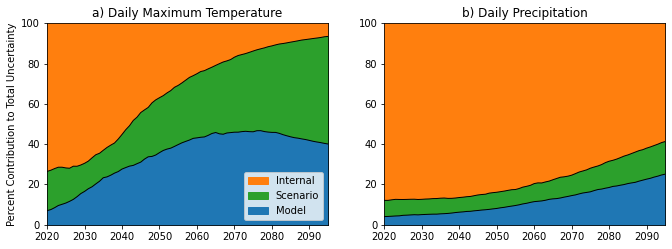

In [30]:
fig, axes = plt.subplots(nrows=1,ncols=2, constrained_layout=True,figsize=(14*2/3,7/2))

for ax, results, title, y_label in zip(axes.ravel(), data, titles, y_labels):

    time=results.sel(time=slice('2020', None)).time.values

    y1 = get_global_mean(results['frac_M_LE']).sel(time=slice('2020', None))*100
    y2 = y1 + get_global_mean(results['frac_S_LE']).sel(time=slice('2020', None))*100
    
    ax.fill_between(time,y2,100,label='Internal',color='#ff7f0e')
    ax.fill_between(time,y1,y2,label='Scenario',color='#2ca02c')
    ax.fill_between(time,0,y1,label='Model',color='#1f77b4')
    ax.plot(time,y1,color='k',linewidth=1)
    ax.plot(time,y2,color='k',linewidth=1)

    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    ax.set_ylim(bottom=0,top=100)
    ax.set_title(title)
    ax.set_xlabel('')

    if y_label:
        ax.set_ylabel(y_label)
axes[0].legend(loc=4)

plt.subplots_adjust(left=0.07, right=0.99, bottom=0.1, top=0.9, wspace=0.20, hspace=0.3)  # all parameters MUST be specified for reproducibility!
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.


In [31]:
fig.savefig('./plots/global_percent_contribution.png', dpi=200)

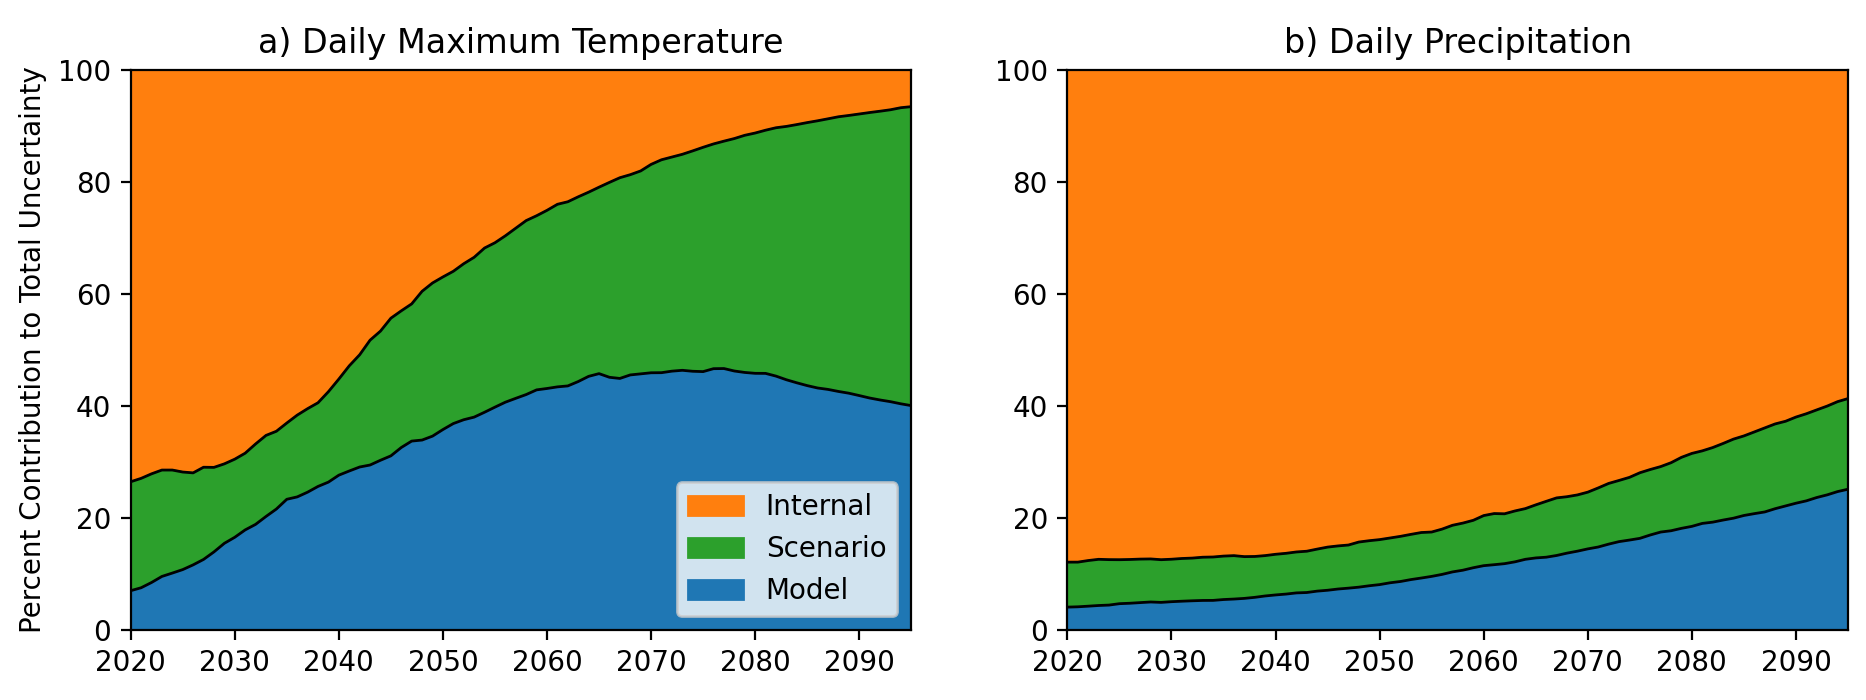

In [32]:
Image(filename='./plots/global_percent_contribution.png')   # Don't believe what Jupyter shows you!

## Signal to noise ratio

In [33]:
data = [mmle_tasmax, mmle_pr]

titles = [
    'a) Daily Maximum Temperature',
    'b) Daily Precipitation'
]
y_labels = [
    'Signal to Noise Ratio',
    None
]

In [34]:
def get_signal_to_noise_ratio(signal, noise):
    snr = np.abs(signal/ np.sqrt(noise))
    return snr

/tmp/ipykernel_11560/2237441847.py:40: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.09, right=0.99, bottom=0.1, top=0.9, wspace=0.20, hspace=0.1)  # all parameters MUST be specified for reproducibility!


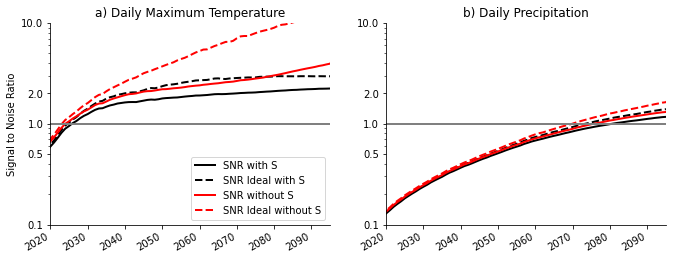

In [35]:
fig, axes = plt.subplots(nrows=1,ncols=2, constrained_layout=True,figsize=(9.5,7/2))

for ax, mmmle_data, title, y_label in zip(axes.ravel(), data, titles, y_labels):

    ref = mmmle_data.x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model'))
    signal = mmmle_data.x.mean(('member_id', 'model')) - ref

    SNR = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE'])
    SNR_ideal = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE_ideal'])

    SNR_no_S = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE_no_S'])
    SNR_ideal_no_S =get_signal_to_noise_ratio(signal, mmmle_data.results['Ibar_LE'])

    get_global_mean(SNR).plot(ax=ax, lw=2, label='SNR with S',color='k')
    get_global_mean(SNR_ideal).plot(ax=ax, lw=2, label='SNR Ideal with S',linestyle='dashed',color='k')
    
    get_global_mean(SNR_no_S).plot(ax=ax, lw=2, label='SNR without S',color='r')
    get_global_mean(SNR_ideal_no_S).plot(ax=ax, lw=2, label='SNR Ideal without S',color='r',linestyle='dashed')

    ax.axhline(1,color='gray',linewidth=2)
    
        # x.sel(variable=v, region=r, model=m).plot(ax=ax, c=colors[im], hue='member_id',add_legend=False, alpha=0.1)
    ax.set_xlim(np.datetime64('2020'), np.datetime64('2095'))
    # ax.set_ylim(bottom=0)

    ax.set_yscale('log')
    ax.set_yticks([0.1, 0.5, 1, 2, 10])
    ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylim(bottom=0.1,top=10)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    # ax.spines["bottom"].set_position(("axes", -0.03)) 
    # ax.spines["left"].set_position(("axes", -0.02))

    if y_label:
        ax.set_ylabel(y_label)
axes[0].legend(loc=4)
plt.subplots_adjust(left=0.09, right=0.99, bottom=0.1, top=0.9, wspace=0.20, hspace=0.1)  # all parameters MUST be specified for reproducibility!
#fig.patch.set_facecolor('0.9')   # Hack to get gray

In [36]:
fig.savefig('./plots/global_snr.png', dpi=200)

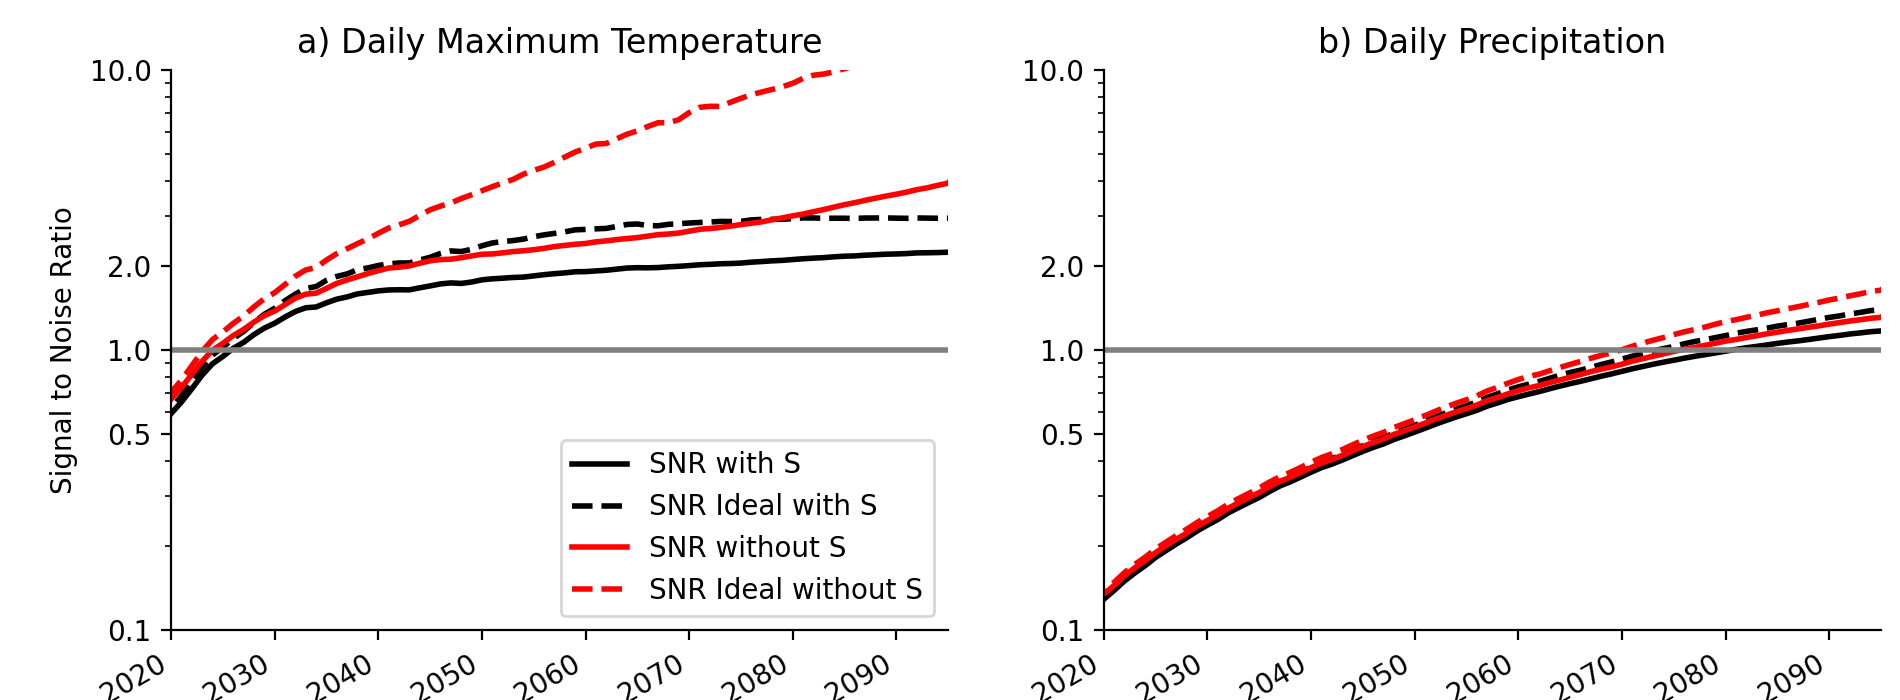

In [37]:
Image(filename='./plots/global_snr.png')   # Don't believe what Jupyter shows you!

## By decades

In [62]:
titles = [
    'SNR with S',
    'SNR Ideal with S',
    'SNR without S',
    'SNR Ideal without S'
]

y_labels = [
    f'1st decade\n({list(years_1)[0]}-{list(years_1)[1]})',
    f'3rd decade\n({list(years_2)[0]}-{list(years_2)[1]})',
    f'6th decade\n({list(years_3)[0]}-{list(years_3)[1]})',
]

### Colorbar

In [56]:
colors = ["mediumslateblue", "lightskyblue", "seashell", "gold", "tomato", "darkred"]
cmap = mpl.colors.ListedColormap(colors, 6)
#cmap = cm.get_cmap('magma_r', 6) # define the colormap
# extract all colors from the .jet map

# define the bins and normalize
bounds = [0, 0.5, 1, 2, 4, 8, 16]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

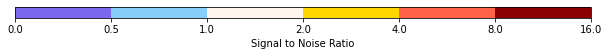

In [57]:
a = np.array([[0,10]])
fig = pl.figure(figsize=(10, 0.25))
img = pl.imshow(a, cmap=cmap, norm=norm)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
clb = pl.colorbar(orientation="horizontal", cax=cax)
cax.set_xlabel('Signal to Noise Ratio', fontsize=10)  # cax == cb.ax
cax.tick_params(labelsize=10)
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
pl.savefig(f'./plots/colorbar_snr_tasmax.png', dpi=200, bbox_inches='tight')

### Maximum temperature

In [68]:
mmmle_data = mmle_tasmax


ref = mmmle_data.x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model'))
signal = mmmle_data.x.mean(('member_id', 'model')) - ref

SNR = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE'])
SNR_ideal = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE_ideal'])

SNR_no_S = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE_no_S'])
SNR_ideal_no_S =get_signal_to_noise_ratio(signal, mmmle_data.results['Ibar_LE'])

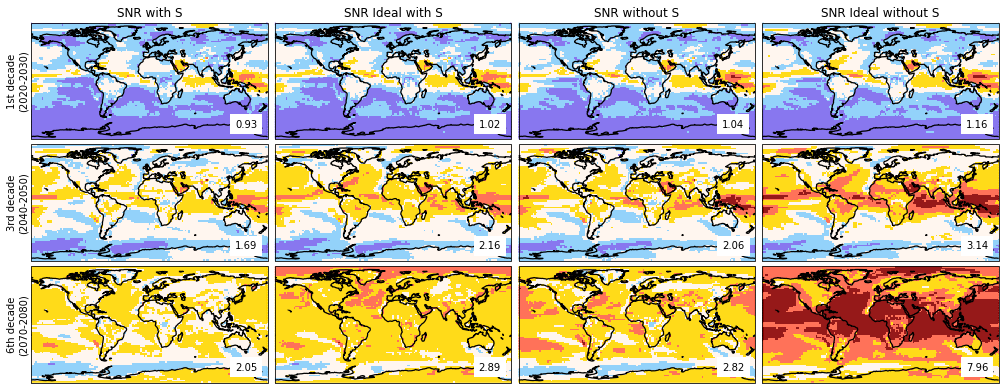

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14,7*(3/4)), subplot_kw=dict(projection=ccrs.PlateCarree()))

for axe, year_slice, y_label in zip(axes, years, y_labels):    
    data_is = [SNR, SNR_ideal, SNR_no_S, SNR_ideal_no_S]

    for ax, data_i, title in zip(axe, data_is, titles):

        data_decade = data_i.sel(time=year_slice).mean('time')
        percentage = np.round(get_global_mean(data_decade), 2).values

        data_decade.plot(
            ax=ax, cmap=cmap, norm=norm, vmin = 0, vmax = 16, alpha=0.9, add_colorbar = False)

        ax.text(130, -70, f'{percentage}',
            bbox={'facecolor': 'white', 
                'alpha': 1, 'pad': 5, 
                'edgecolor' : 'none'})

        if (axe == axes[0]).all():
            ax.set_title(title)
        else:
            ax.set_title(None)

        if ax == axe[0]:
            ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes)
        ax.coastlines(linewidth=1.25, color='k')
        
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.


In [43]:
variable = 'tasmax'
fig.savefig(f'./plots/global_snr_{variable}_by_decades.png', dpi=200)

### Precipitation

In [66]:
mmmle_data = mmle_pr


ref = mmmle_data.x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model'))
signal = mmmle_data.x.mean(('member_id', 'model')) - ref

SNR = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE'])
SNR_ideal = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE_ideal'])

SNR_no_S = get_signal_to_noise_ratio(signal, mmmle_data.results['T_LE_no_S'])
SNR_ideal_no_S =get_signal_to_noise_ratio(signal, mmmle_data.results['Ibar_LE'])



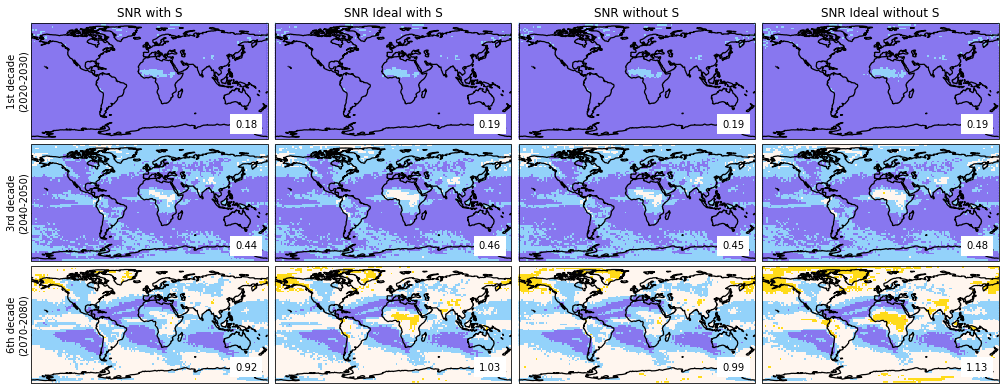

In [67]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14,7*(3/4)), subplot_kw=dict(projection=ccrs.PlateCarree()))

for axe, year_slice, y_label in zip(axes, years, y_labels):    
    data_is = [SNR, SNR_ideal, SNR_no_S, SNR_ideal_no_S]

    for ax, data_i, title in zip(axe, data_is, titles):

        data_decade = data_i.sel(time=year_slice).mean('time')
        percentage = np.round(get_global_mean(data_decade), 2).values

        data_decade.plot(
            ax=ax, cmap=cmap, norm=norm, vmin = 0, vmax = 16, alpha=0.9, add_colorbar = False)

        ax.text(130, -70, f'{percentage}',
            bbox={'facecolor': 'white', 
                'alpha': 1, 'pad': 5, 
                'edgecolor' : 'none'})

        if (axe == axes[0]).all():
            ax.set_title(title)
        else:
            ax.set_title(None)

        if ax == axe[0]:
            ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes)
        ax.coastlines(linewidth=1.25, color='k')
        
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.


In [46]:
variable = 'pr'
fig.savefig(f'./plots/global_snr_{variable}_by_decades.png', dpi=200)

## Max % improvement

Figure 7: max \% improvement in std space (from T to T-ideal, again not sure whether to include S, do both for now)
* T = M + I
* T_ideal = I 
* (1 - std(T_ideal) / std(T)) * 100

In [47]:
titles = [
    'Max Temp: Max improvement with S',
    'Max Temp: Max improvement without S',
    'Precip: Max improvement with S',
    'Precip: Max improvement without S'
]

y_labels = [
    f'1st decade\n({list(years_1)[0]}-{list(years_1)[1]})',
    f'3rd decade\n({list(years_2)[0]}-{list(years_2)[1]})',
    f'6th decade\n({list(years_3)[0]}-{list(years_3)[1]})',
]

In [48]:
# def improvement_without_S(data):
#     ideal = data['Ibar_LE'].std('time')
#     total =  data['T_LE_no_S'].std('time')
#     return abs((total-ideal)/total)*100

def improvement_without_S(data):
    total = np.sqrt(data['T_LE_no_S']).mean('time')
    ideal = np.sqrt(data['Ibar_LE']).mean('time')
    improvement = (1-ideal / total)*100
    return improvement

In [49]:
# def improvement_with_S(data):
#     ideal = data['T_LE_ideal'].std('time')
#     total =  data['T_LE'].std('time')
#     return abs((total-ideal)/total)*100

def improvement_with_S(data):
    total = np.sqrt(data['T_LE']).mean('time')
    ideal = np.sqrt(data['T_LE_ideal']).mean('time')
    improvement = (1-ideal / total)*100
    return improvement

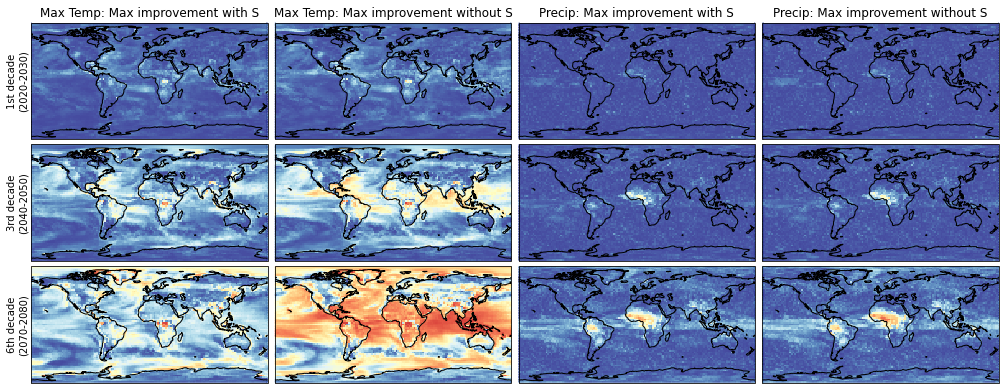

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(14,7*(3/4)), subplot_kw=dict(projection=ccrs.PlateCarree()))
reversed_map = plt.cm.RdYlBu_r   # Hack for getting reverse colormaps in matplotlib

for axe, year_slice, y_label in zip(axes, years, y_labels):    
    data_is = [
        improvement_with_S(mmle_tasmax.results.sel(time=year_slice)),
        improvement_without_S(mmle_tasmax.results.sel(time=year_slice)),
        improvement_with_S(mmle_pr.results.sel(time=year_slice)),
        improvement_without_S(mmle_pr.results.sel(time=year_slice)),
    ]
    
    for ax, data_i, title in zip(axe, data_is, titles):
        percentage = int(np.round((data_i.mean(('lat', 'lon'))*100).values))

        convert_longitude_360to180(data_i).plot(
            ax=ax, cmap=reversed_map, vmin = 0, vmax = 100, alpha=0.9, add_colorbar = False)

        if (axe == axes[0]).all():
            ax.set_title(title)
        else:
            ax.set_title(None)

        if ax == axe[0]:
            ax.text(-0.01, 0.5, y_label, va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes)
        ax.coastlines(linewidth=1, color='k')
        
# plt.subplots_adjust(left=0.05, bottom=0.02, wspace=0, hspace=0.03)
plt.subplots_adjust(left=0.03, right=0.99, bottom=0.01, top=0.97, wspace=0.03, hspace=0.02)  # all parameters MUST be specified for reproducibility!
# plt.show()   # Not really necessary
#fig.patch.set_facecolor('0.9')   # Hack to get grayscale. To see actual figure size.
# Add colorbar in post-production, plot separately, then cut and paste in PowerPoint, etc.

In [51]:
fig.savefig('./plots/max_improvement_over_time.png', dpi=200, bbox_inches='tight')

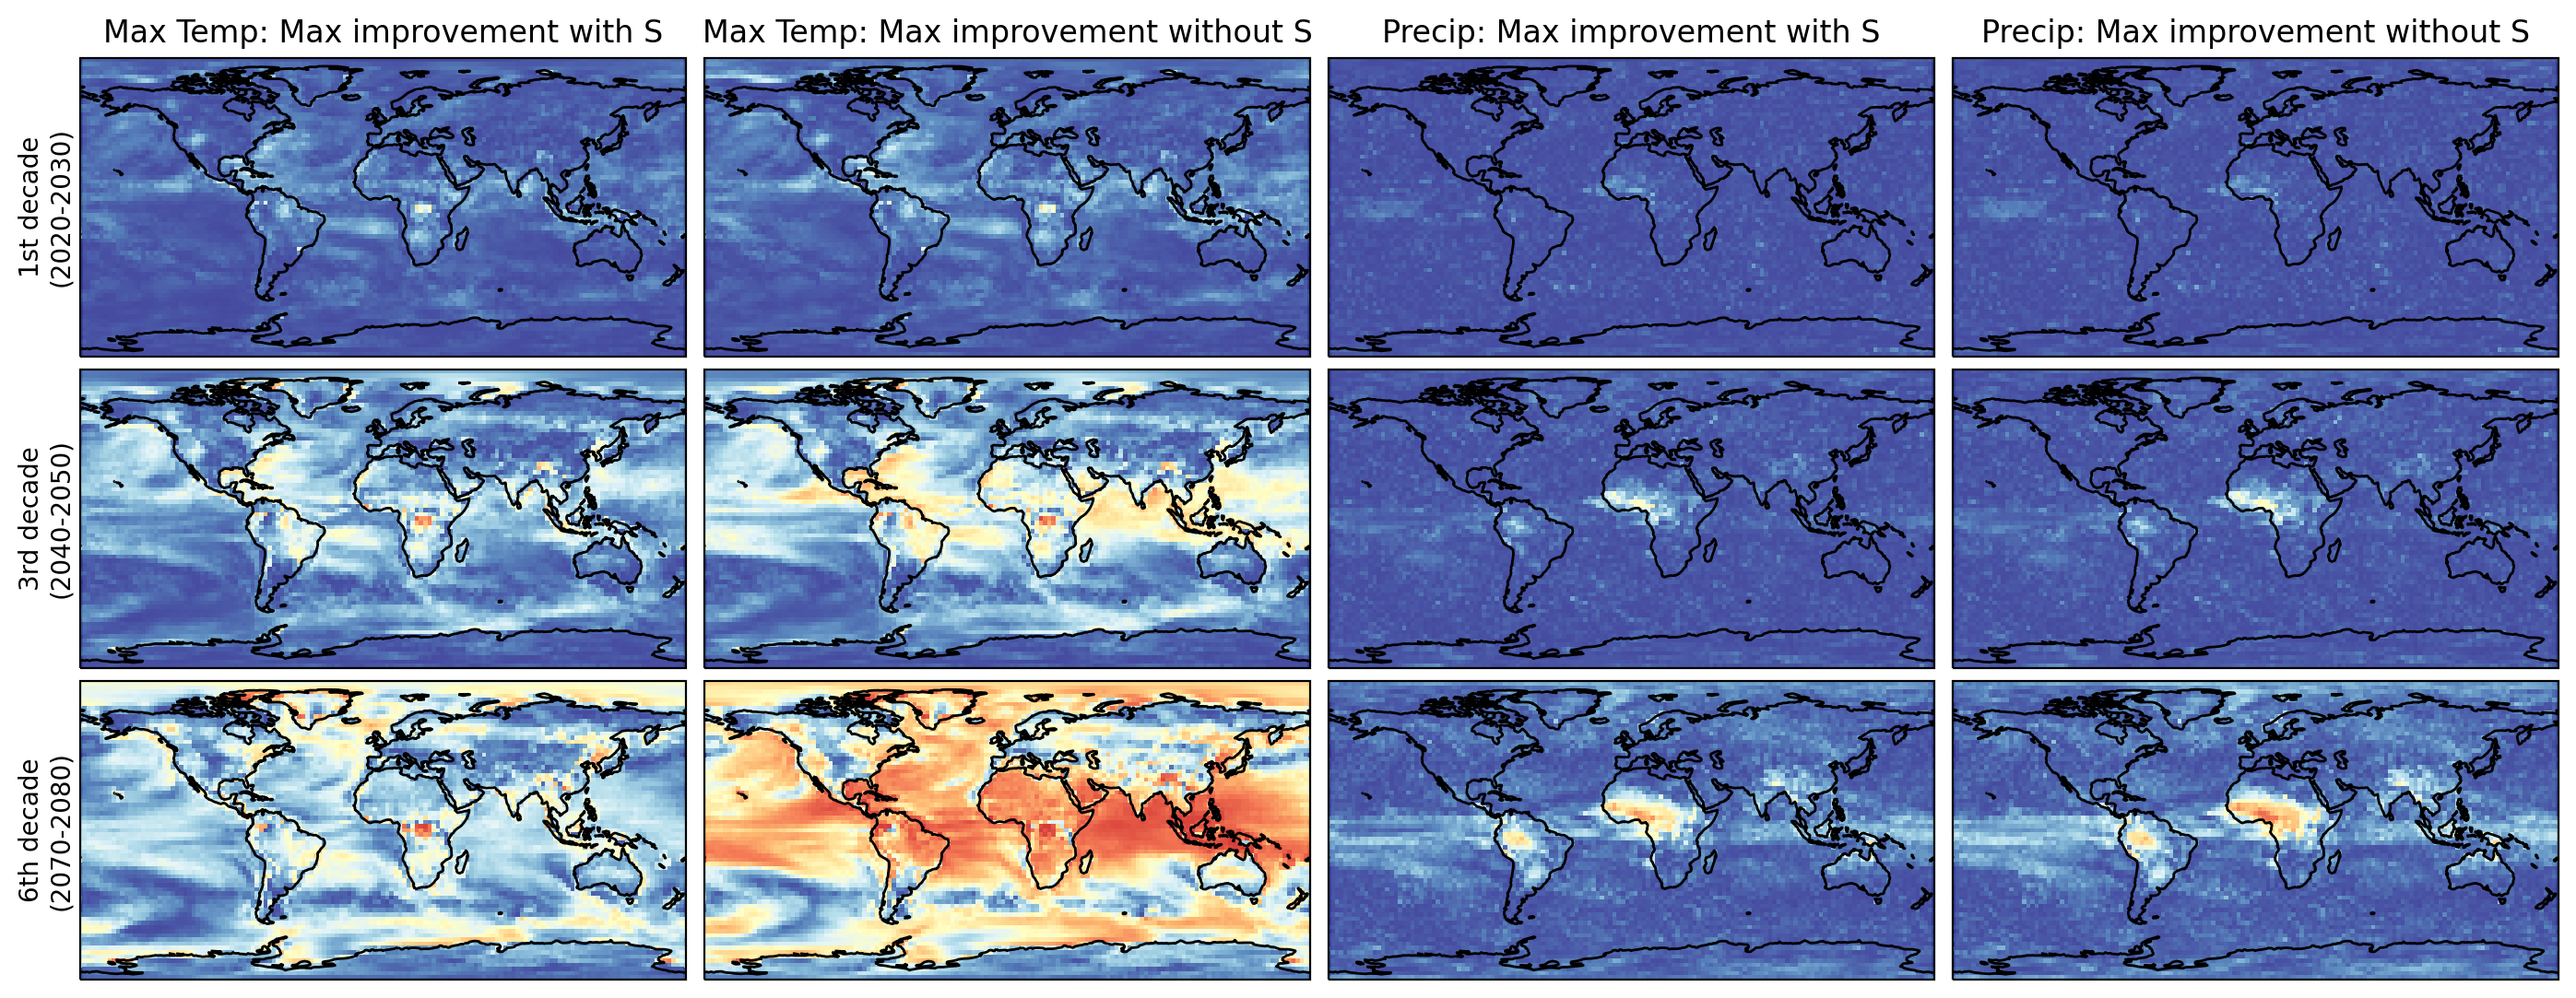

In [52]:
Image(filename='./plots/max_improvement_over_time.png')   # Don't believe what Jupyter shows you!


# Colorbar

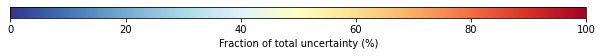

In [53]:
a = np.array([[0,100]])
fig = pl.figure(figsize=(10, 0.25))
img = pl.imshow(a, cmap=reversed_map)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(orientation="horizontal", cax=cax)
cax.set_xlabel('Fraction of total uncertainty (%)', fontsize=10)  # cax == cb.ax
cax.tick_params(labelsize=10)
pl.savefig(f'./plots/colorbar_100.png', dpi=200, bbox_inches='tight')


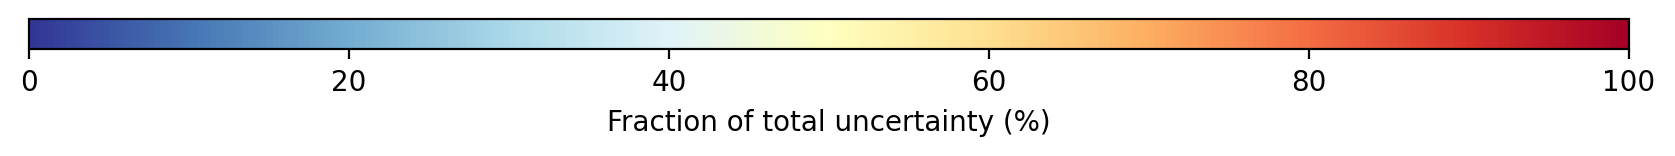

In [54]:
Image(filename='./plots/colorbar_100.png')   # Don't believe what Jupyter shows you!

In [55]:
# region1 = Seattle, region2 = Sydney Australia, region3 = Lagos Nigeria 
regions = ['Seattle', 'Sydney', 'Lagos']
lats = [47.6, -33.8, 6.5]
lons = [237.7, 151.2, 3.4]
region_dim = xr.DataArray(regions, coords={'region': regions})